# Lab３ Merton Model

**Purpose:** Implementing the Merton model is pretty easy but you have to make a lot of more or
less arbitrary choices when estimating the model. The purpose of the exercise is to investigate
how sensitive the probability of default (PD) is to these choices. You can use my function
mymerton, or if you like numerical optimization you can write your own function (writing your
own function is not needed for full credits).

## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
from matplotlib import pyplot as plt
from scipy.optimize import minimize

## Step 2: Load Data
**Data:** The data are in the Excel files DataLab3accounting.xlsx, DataLab3prices.xlsx and DataLab3rf.xlsx in Canvas. The data is identical to the data used in the lecture on the merton model. For the accounting data CUSIP is a firm identifier from Compustat, LCT is total current liabilities, DLTT is long term debt, CSHO is number of shares, fyear is fiscal year. All amounts in MUSD. The firm is AAC Holdings. For the file DataLab3prices.xlsx Cusip is a firm identifier, Date is, well the date, and Prices is the close price of the stock. DataLab3rf.xlsx contains monthly 1-month T-bill expressed as annual interest rates (the zeros are correct and are not missing values).

In [2]:
# Read CSV files
accounting_data = pd.read_excel('D:\\2023semester\\Lund University\\Financial Risk Management\\lab3\\DataLab3accounting.xlsx')
price_data = pd.read_excel('D:\\2023semester\\Lund University\\Financial Risk Management\\lab3\\DataLab3prices.xlsx')
risk_free = pd.read_excel('D:\\2023semester\\Lund University\\Financial Risk Management\\lab3\\DataLab3rf.xlsx')
print(accounting_data.head())
print(price_data.head())
print(risk_free.head())

    CUSIP     LCT     DLTT    CSHO  fyear
0  307108  34.337  140.335  22.814   2015
   Cusip      Date  Prices
0  30710  20150102   30.21
1  30710  20150105   29.73
2  30710  20150106   29.38
3  30710  20150107   28.64
4  30710  20150108   29.37
     Date  Riskfree
0  201501       0.0
1  201502       0.0
2  201503       0.0
3  201504       0.0
4  201505       0.0


## Step 3: Define my_merton Function

In [3]:
def my_merton(x,sige,E,d,rf,t):
     d1 = (np.log(x[1]/d)+(rf+0.5*x[0]**2)*t)/(x[0]*np.sqrt(t))
     d2 = d1-x[0]*np.sqrt(t)
     f1 = x[1]*norm.cdf(d1)-np.exp(-rf*t)*d*norm.cdf(d2)-E # This is the equation on slide 21 Video L13
     f2 = (x[1]/E)*norm.cdf(d1)*x[0]-sige # This is the equation on slide 22 Video L13
     return np.sqrt(f1**2+f2**2) # Minimize f over x(1) and x(2) solves for Equity vol and Asset value

equityReturns = np.log(price_data.Prices/price_data.Prices.shift(1))
equityReturns = equityReturns[1:-1] # Removing the nan created by calculating returns
sige = stats.tstd(equityReturns)*np.sqrt(250) # Standard deviation of equity (returns) scaled to yearly
K = accounting_data.LCT+0.1*accounting_data.DLTT # We use 10% of long term debt which was found best in Afik et al. (2016)
E = accounting_data.CSHO*price_data.Prices.iloc[-1] # Equity in MUSD as Number of shares * last share price
rf = np.mean(risk_free.Riskfree) # Risk free rate as average of monthly rates
t = 1 # We want PD in 1 year
x0=(sige,K[0]+E[0]) # Initial quess for asset volatility and asset value,
                    # easier and faster for numerical optimization if guess is good
x0bad = (sige,400)


res = minimize(my_merton, x0bad, method='BFGS', args=(sige,E[0],K[0],rf,t), options={'disp': False})
print("Asset volatility is {:.3f} and asset value is {:.2f}".format(res.x[0],res.x[1]))

DD = (np.log(res.x[1])+(rf-0.5*res.x[0]**2)*np.sqrt(t)-np.log(K))/(res.x[0]*np.sqrt(t)) # DD slide 9 VL 13
PD = norm.cdf(-DD)
print("PD within one year is {:.8f}".format(PD[0]))

Asset volatility is 0.599 and asset value is 700.58
PD within one year is 0.00001546


## Step 4. Test Sensitivity to Short- and Long-Term Debt Weighting
**Long and short term debt:** Merton assumes all debt has the same maturity but in practice
the Merton model often works better if we care more about short term debt than long term
debt. We can do this by calculating total debt $K$ as $K = STD + kLT D, 0 < k < 1,$ $STD$ is
short term debt and $LTD$ is long term debt. Show in a graph how the PD (one year ahead)
varies for $k = 0.1, 0.2..., 0.9.$ Use the full year of observations for calculating equity volatility
and the risk free rate of return.




For k = 0.1, PD = 0.00001546
For k = 0.2, PD = 0.00000001
For k = 0.3, PD = 0.00014162
For k = 0.4, PD = 0.00028424
For k = 0.5, PD = 0.00049151
For k = 0.6, PD = 0.00076581
For k = 0.7, PD = 0.00110575
For k = 0.8, PD = 0.00150742
For k = 0.9, PD = 0.00196545


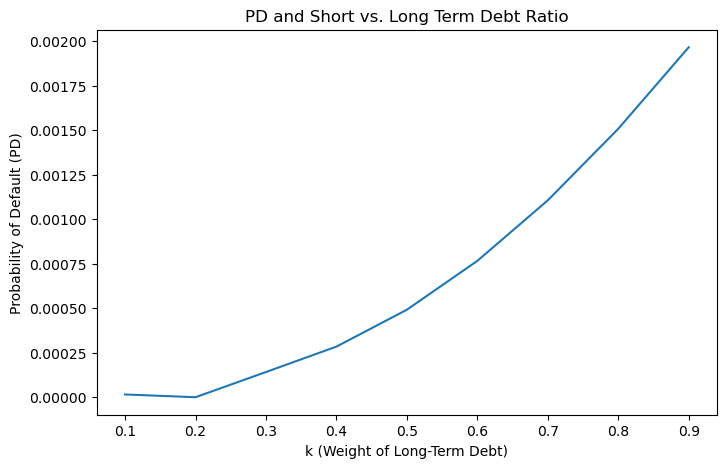

In [4]:
k_values = np.linspace(0.1, 0.9, 9)
PDs = []
equityReturns = np.log(price_data.Prices / price_data.Prices.shift(1))[1:-1]
rf = np.mean(risk_free.Riskfree) # Risk free rate as average of monthly rates
t = 1 # We want PD in 1 year


for k in k_values:
    # Calculate total debt with weighting
    K = accounting_data.LCT+k*accounting_data.DLTT

    # Calculate equity value
    E = accounting_data.CSHO*price_data.Prices.iloc[-1] # Equity in MUSD as Number of shares * last share price

    # Calculate equity volatility (full year)
    sige = stats.tstd(equityReturns) * np.sqrt(250)

    # Calculate PD using my Merton function
    res = minimize(my_merton, x0bad, method='BFGS', args=(sige, E[0], K, rf, t), options={'disp': False})
    DD = (np.log(res.x[1])+(rf-0.5*res.x[0]**2)*np.sqrt(t)-np.log(K))/(res.x[0]*np.sqrt(t)) # DD slide 9 VL 13
    PD = norm.cdf(-DD)
    PDs.append(PD)
    print("For k = {:.1f}, PD = {:.8f}".format(k, PD[0]))

# Plot PD vs. k values
plt.figure(figsize=(8, 5))
plt.plot(k_values, PDs)
plt.xlabel('k (Weight of Long-Term Debt)')
plt.ylabel('Probability of Default (PD)')
plt.title('PD and Short vs. Long Term Debt Ratio')
plt.show()

## Step 5: Time-Varying Volatility and PD
Merton assumes that the equity volatility is constant but in practice
we know that volatility varies over time. You should now investigate how sensitive PD is
to different ways of estimating equity volatility. You can show the results in a table and/or
in a graph.

(1) Use the standard deviation of returns for the $x$ most recent months with $x = 1, 3, 6, 9, 12$ so e.g. for $x=1$ use only the returns for december and for $x=12$ use all of the returns.

(2) Also use the average volatility from an EWMA model with $λ = 0.94$ (see code from Lecture 4) for estimating the volatility.

Use the full year of returns for the EWMA model, also use the full year of observations for calculating the risk free rate and use $k = 0.5$ in $K = STD + kLTD.$

For x = 1, sige = 0.13507063, PD = 0.00000000
For x = 3, sige = 0.28072741, PD = 0.00000000
For x = 6, sige = 0.50180124, PD = 0.00000643
For x = 9, sige = 0.56049477, PD = 0.00005725
For x = 12, sige = 0.64307979, PD = 0.00049151


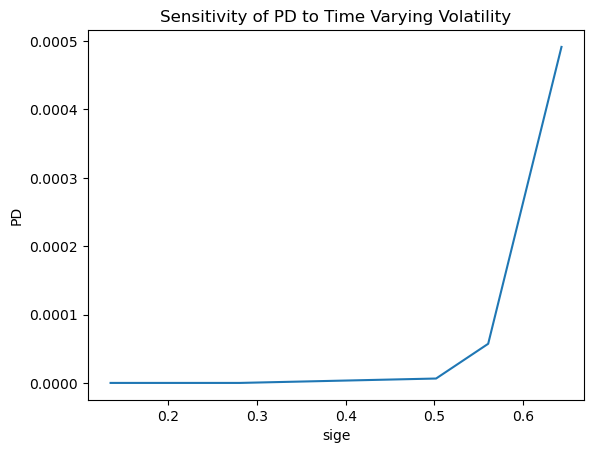

In [5]:
#Time varying volatility using std of recent months
price_data.reset_index(inplace=True)
price_data['Date'] = pd.to_datetime(price_data['Date'], format='%Y%m%d')
price_data.set_index('Date', inplace=True)

x_values = [1, 3, 6, 9, 12]
PD_values_volatility = []
sige_values = []

for x in x_values:
    end_date = pd.Timestamp("2015-12-31")
    if x == 1:
        start_date = pd.Timestamp("2015-12-01")
    elif x == 3:
        start_date = pd.Timestamp("2015-10-01")
    elif x == 6:
        start_date = pd.Timestamp("2015-07-01")
    elif x == 9:
        start_date = pd.Timestamp("2015-04-01")
    elif x == 12:
        start_date = pd.Timestamp("2015-01-02")

    prices_windows = price_data[start_date:end_date]['Prices']
    equityReturns = np.log(prices_windows / prices_windows.shift(1))
    equityReturns = equityReturns[1:-1]

    trading_days = len(prices_windows)-2
    sige = stats.tstd(equityReturns)*np.sqrt(trading_days)
    K = accounting_data.LCT+0.5*accounting_data.DLTT # 50% of long term debt
    rf = np.mean(risk_free.Riskfree) # Risk free rate as average of monthly rates
    E = accounting_data.CSHO*price_data.Prices.iloc[-1] # Equity in MUSD as Number of shares * last share price
    t = 1 # We want PD in 1 year
    x0=(sige,K[0]+E[0]) #asset volatility and Initial asset value,
    x0bad = (sige,400)   #asset volatility and set Initial asset value randomly of 400, then minimize

    res = minimize(my_merton, x0bad, method='BFGS', args=(sige, E[0], K[0], rf, t), options={'disp': False})
    DD = (np.log(res.x[1])+(rf-0.5*res.x[0]**2)*np.sqrt(t)-np.log(K))/(res.x[0]*np.sqrt(t))
    PD = norm.cdf(-DD)
    PD_values_volatility.append(PD[0])
    sige_values.append(sige)
    print("For x = {}, sige = {:.8f}, PD = {:.8f}".format(x, sige, PD[0]))


plt.plot(sige_values, PD_values_volatility)
plt.title('Sensitivity of PD to Time Varying Volatility')
plt.xlabel('sige')
plt.ylabel('PD')
plt.show()


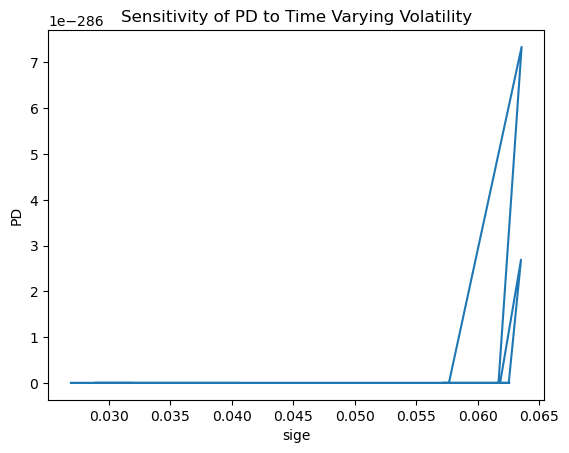

     EWMA Volatility (sige)  Probability of Default (PD)
0                  0.040591                          0.0
1                  0.039549                          0.0
2                  0.038454                          0.0
3                  0.037802                          0.0
4                  0.037166                          0.0
..                      ...                          ...
246                0.034948                          0.0
247                0.034292                          0.0
248                0.033843                          0.0
249                0.032864                          0.0
250                0.031869                          0.0

[251 rows x 2 columns]


In [6]:
#Time varying volatility using EWMA
PD_values_EWMA = []
equityReturns = np.log(price_data.Prices/price_data.Prices.shift(1))
equityReturns = equityReturns[1:-1]

var = [np.var(equityReturns)]
lambda_par = 0.94 # RiskMetrics
T=len(equityReturns)
for j in range(1,T+1):
    var.append((1-lambda_par)*equityReturns[j-1]**2+lambda_par*var[j-1])
var = np.array(var)
sige = var**0.5

K = accounting_data.LCT+0.5*accounting_data.DLTT # 50% of long term debt
E = accounting_data.CSHO*price_data.Prices.iloc[-1] # Equity in MUSD as Number of shares * last share price
rf = np.mean(risk_free.Riskfree) # Risk free rate as average of monthly rates
t = 1 # We want PD in 1 year

for s in sige:
    x0=(s,K[0]+E[0]) #asset volatility and Initial asset value,
    x0bad = (s,400)   #asset volatility and set Initial asset value randomly of 400, then minimize
    res = minimize(my_merton, x0bad, method='BFGS',     #(Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton method for unconstrained optimization problems.
               args=(s,E[0],K[0],rf,t), options={'disp': False})   #not show progress


    DD = (np.log(res.x[1])+(rf-0.5*res.x[0]**2)*np.sqrt(t)-np.log(K))/(res.x[0]*np.sqrt(t))  #x[0]:Asset volitility, x[1]:Initial asset value
    PD = norm.cdf(-DD)
    PD_values_EWMA.append(PD[0])

plt.plot(sige, PD_values_EWMA)
plt.title('Sensitivity of PD to Time Varying Volatility')
plt.xlabel('sige')
plt.ylabel('PD')
plt.show()

sige_pd_df = pd.DataFrame({
    'EWMA Volatility (sige)': sige,
    'Probability of Default (PD)': PD_values_EWMA
})
print(sige_pd_df)

## 3D-Plot
**Extra not needed for full credit** Combine the different choices of k for the different volatility
estimates (skip EWMA) so that you use each method for estimating the volatility for each value
of k. Present the results in a surface plot.


C:\Users\YQQ\AppData\Local\Temp\ipykernel_3080\264693308.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  PD_values_surface[i][j] = PD
C:\Users\YQQ\AppData\Local\Temp\ipykernel_3080\264693308.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  PD_values_surface[i][j] = PD
C:\Users\YQQ\AppData\Local\Temp\ipykernel_3080\264693308.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  PD_values_surface[i][j] = PD
C:\Users\YQQ\AppData\Local\Temp\ipykernel_3080\26469

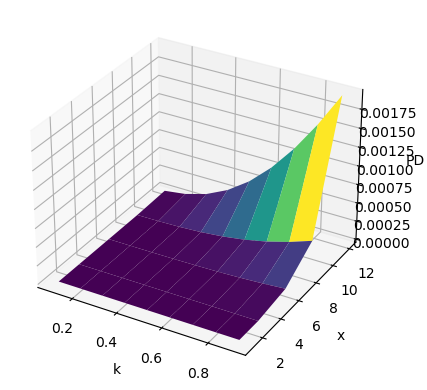

In [7]:
k_values = np.linspace(0.1, 0.9, 9)
x_values = [1, 3, 6, 9, 12]

PD_values_surface = np.zeros((len(k_values), len(x_values)))

for i, k in enumerate(k_values):
    for j, x in enumerate(x_values):
        K = accounting_data.LCT + k * accounting_data.DLTT
        end_date = pd.Timestamp("2015-12-31")
        if x == 1:
            start_date = pd.Timestamp("2015-12-01")
        elif x == 3:
            start_date = pd.Timestamp("2015-10-01")
        elif x == 6:
            start_date = pd.Timestamp("2015-07-01")
        elif x == 9:
            start_date = pd.Timestamp("2015-04-01")
        elif x == 12:
            start_date = pd.Timestamp("2015-01-02")

        prices_windows = price_data[start_date:end_date]['Prices']
        equityReturns = np.log(prices_windows / prices_windows.shift(1))
        equityReturns = equityReturns[1:-1]
        trading_days = len(prices_windows)-2
        sige = stats.tstd(equityReturns)*np.sqrt(trading_days)

        # Calculate PD
        E = accounting_data.CSHO*price_data.Prices.iloc[-1]
        x0=(sige,K[0]+E[0])
        res = minimize(my_merton, x0bad, method='BFGS', args=(sige, E[0], K[0], rf, t), options={'disp': False})
        DD = (np.log(res.x[1])+(rf-0.5*res.x[0]**2)*np.sqrt(t)-np.log(K))/(res.x[0]*np.sqrt(t))
        PD = norm.cdf(-DD)
        PD_values_surface[i][j] = PD

from mpl_toolkits.mplot3d import Axes3D

K, X = np.meshgrid(k_values, x_values)
K = K.T
X = X.T
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K, X, PD_values_surface, cmap='viridis')
ax.set_xlabel('k')
ax.set_ylabel('x')
ax.set_zlabel('PD')
plt.show()

## Conclusions

**a. Which input is the Merton models most sensitive to?**

Based on step 4 (K: Short- and Long-Term Debt) and step 5 (sige: Equity volatility) figures, the Merton model is more sensitive to equity volatility, as seen from steeper slope of the line.
*   **k Values:** The probability of default (PD) tends to increase as the value of k increases. This suggests that the model becomes more conservative in predicting default as a larger portion of long-term debt is considered in the total debt calculation.
*   **Volatility Estimation Method / the Length of the Time Window(x):** The PD values vary depending on the method used to estimate volatility. While the EWMA method resulted in consistently lower PD values, the fixed window methods showed varying PD values depending on the length of the time window used for calculating volatility. Generally, higher values of volatility result in higher PD values.



**b. Given the sensitivity, do you think the Merton model is a useful model for risk management?**

Yes. The Merton model, despite its sensitivity to input parameters, can still be a useful tool for risk management when used appropriately and in conjunction with other risk assessment techniques.


The model provides valuable insights into default risk and can help in assessing the impact of different factors such as debt structure and asset volatility on the probability of default.


However, it's crucial to recognize the limitations of the model and consider the uncertainties associated with parameter estimates. Sensitivity analyses, like the one conducted here, can help in understanding the model's robustness and identifying areas where improvements or adjustments may be necessary.


Additionally, combining the Merton model with other risk management approaches, such as stress testing and scenario analysis, can enhance its effectiveness in capturing the complexities of real-world financial systems and improving decision-making processes.







